In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-clean/cleaned_data(defoult).csv


In [51]:
# Импорт основных библиотек для работы:
# - warnings: отключаем ненужные предупреждения
# - pandas/numpy: работа с данными
# - seaborn/matplotlib: визуализация
# Также фиксируем стиль графиков и random_state для воспроизводимости
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

RANDOM_STATE = 42

In [52]:
# Загружаем датасет заранее очищенный кредитного скоринга UCI.
# Смотрим форму датафрейма и первые строки, чтобы понять структуру данных.

df = pd.read_csv('/kaggle/input/data-clean/cleaned_data(defoult).csv')
print(df.shape)
df.head()
df['default.payment.next.month'].value_counts(normalize=True)

(30000, 24)


default.payment.next.month
0    0.7788
1    0.2212
Name: proportion, dtype: float64

In [53]:
# Разделяем X и y: целевая переменная - default.payment.next.month.
# Категориальные признаки кодируем OneHotEncoder.
# Числовые - нормируем StandardScaler.
# ColumnTransformer позволяет собрать всё в единую матрицу признаков.

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

y = df['default.payment.next.month']
X = df.drop(columns=['default.payment.next.month'])

categorical = ['SEX', 'EDUCATION', 'MARRIAGE']
numerical = [c for c in X.columns if c not in categorical]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(drop='first'), categorical)
])

X_processed = preprocessor.fit_transform(X)
X_processed.shape


(30000, 30)

In [54]:
# Делим данные на обучающую и тестовую выборки.
# Используем stratify=y, чтобы сохранить исходное соотношение классов.
# Это важно при несбалансированных данных.

from sklearn.model_selection import train_test_split

# Разделяем выборку
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((24000, 30), (6000, 30))

In [55]:
# Создаём baseline модель без подбора параметров.
# Обучаем ее и считаем основные метрики:
# Accuracy, Precision, Recall, F1, ROC AUC.
# Baseline нужен, чтобы потом сравнивать улучшенную модель.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Базовая модель
log_reg = LogisticRegression(max_iter=200, random_state=RANDOM_STATE)
log_reg.fit(X_train, y_train)

# Предсказания
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]

print("Baseline Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Baseline Logistic Regression
Accuracy: 0.809
Precision: 0.6929637526652452
Recall: 0.2449133383571967
F1: 0.3619153674832962
ROC AUC: 0.7100823390024077


<Figure size 600x600 with 0 Axes>

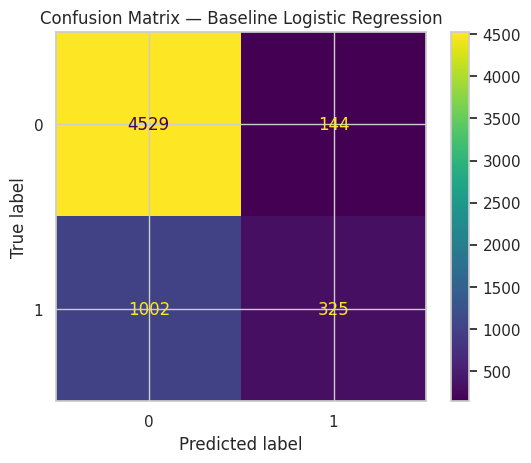

In [56]:
# Строим confusion matrix, чтобы визуально увидеть,
# сколько объектов модель ошибочно относит к каждому классу.

from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — Baseline Logistic Regression")
plt.show()


In [57]:
# Подбираем гиперпараметры логистической регрессии.
# Исследуем различные варианты регуляризации (L1/L2),
# разные значения параметра C и применение class_weight="balanced".
# Оцениваем качество по F1-score, так как данные несбалансированы.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10],
    "class_weight": [None, "balanced"],
    "solver": ["liblinear"],  # поддерживает L1 и L2
}

grid = GridSearchCV(
    LogisticRegression(max_iter=300, random_state=RANDOM_STATE),
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best F1:", grid.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best F1: 0.48238889219947645


In [58]:
# Берём лучшую найденную модель и проверяем её качество на тестовой выборке.
# Улучшенная модель показывает лучший F1-score за счёт более высокого Recall.

best_log = grid.best_estimator_

y_pred_best = best_log.predict(X_test)
y_proba_best = best_log.predict_proba(X_test)[:,1]

print("Improved Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1:", f1_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_proba_best))


Improved Logistic Regression
Accuracy: 0.6803333333333333
Precision: 0.36976641692375495
Recall: 0.6322532027128862
F1: 0.46662958843159064
ROC AUC: 0.7090631602186138


In [ ]:
# Сравниваем две модели по F1-score и ROC AUC.
# Улучшенная модель выигрывает по F1 за счёт роста Recall

print("F1 baseline:", f1_score(y_test, y_pred))
print("F1 improved:", f1_score(y_test, y_pred_best))

print("\nROC AUC baseline:", roc_auc_score(y_test, y_proba))
print("ROC AUC improved:", roc_auc_score(y_test, y_proba_best))


F1 baseline: 0.3619153674832962
F1 improved: 0.46662958843159064

ROC AUC baseline: 0.7100823390024077
ROC AUC improved: 0.7090631602186138


In [ ]:
# Преобразуем разреженные матрицы в плотный numpy-формат,
# чтобы использовать их в самописной логистической регрессии.

import numpy as np

def to_dense(X):
    try:
        return X.toarray()
    except:
        return np.asarray(X)

X_train_np = to_dense(X_train)
X_test_np  = to_dense(X_test)
y_train_np = np.asarray(y_train)
y_test_np  = np.asarray(y_test)

X_train_np.shape, X_test_np.shape, y_train_np.shape, y_test_np.shape


((24000, 30), (6000, 30), (24000,), (6000,))

In [ ]:
# Реализация базовой логистической регрессии:
# - обычный batch gradient descent
# - без регуляризации
# - без class_weight
# - поддержка intercept

import numpy as np
from tqdm.auto import trange

class MyLogisticRegression:
    def __init__(self, lr=0.1, num_iters=1000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iters = num_iters
        self.fit_intercept = fit_intercept
        self.verbose = verbose

    def _add_intercept(self, X):
        if not self.fit_intercept:
            return X
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = self._add_intercept(X)
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        for _ in trange(self.num_iters, disable=not self.verbose):
            z = X.dot(self.w)
            p = self._sigmoid(z)
            grad = X.T.dot(p - y) / n_samples
            self.w -= self.lr * grad

        return self

    def predict_proba(self, X):
        X = self._add_intercept(X)
        return self._sigmoid(X.dot(self.w))

    def predict(self, X, thresh=0.5):
        return (self.predict_proba(X) >= thresh).astype(int)


In [62]:
# Обучаем базовую самописную логистическую регрессию.
# В этой части мы сравним её со sklearn baseline.

mylog = MyLogisticRegression(
    lr=0.5,
    num_iters=1200,
    verbose=False
)

mylog.fit(X_train_np, y_train_np)

y_pred_my = mylog.predict(X_test_np)
y_proba_my = mylog.predict_proba(X_test_np)

print("MyLogistic (baseline)")
print("Accuracy:", accuracy_score(y_test_np, y_pred_my))
print("Precision:", precision_score(y_test_np, y_pred_my))
print("Recall:", recall_score(y_test_np, y_pred_my))
print("F1:", f1_score(y_test_np, y_pred_my))
print("ROC AUC:", roc_auc_score(y_test_np, y_proba_my))


MyLogistic (baseline)
Accuracy: 0.8093333333333333
Precision: 0.6967741935483871
Recall: 0.24415975885455915
F1: 0.3616071428571428
ROC AUC: 0.7085345418557536


In [ ]:
# Улучшенная логистическая регрессия:
# - L2-регуляризация (через параметр C)
# - class_weight='balanced'
# - более стабильный learning rate
# - обучение на всей выборке

class MyLogisticImproved:
    def __init__(self, lr=0.01, num_iters=3000, C=1.0,
                 class_weight=None, fit_intercept=True):
        self.lr = lr
        self.num_iters = num_iters
        self.C = C
        self.lambda_ = 1 / C      # L2-регуляризация
        self.class_weight = class_weight
        self.fit_intercept = fit_intercept

    def _add_intercept(self, X):
        if not self.fit_intercept:
            return X
        return np.hstack((np.ones((X.shape[0], 1)), X))

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = self._add_intercept(X)
        n, m = X.shape
        self.w = np.zeros(m)

        # class_weight
        if self.class_weight:
            sw = np.array([self.class_weight[int(t)] for t in y])
        else:
            sw = np.ones(n)

        # нормируем веса
        sw = sw * (len(sw) / sw.sum())

        for _ in range(self.num_iters):
            z = X.dot(self.w)
            p = self._sigmoid(z)

            error = p - y
            grad = (X * sw[:, None]).T.dot(error) / n

            # L2 регуляризация
            grad[1:] += 2 * self.lambda_ * self.w[1:]

            self.w -= self.lr * grad

        return self

    def predict_proba(self, X):
        X = self._add_intercept(X)
        return self._sigmoid(X.dot(self.w))

    def predict(self, X, thresh=0.5):
        return (self.predict_proba(X) >= thresh).astype(int)


In [64]:
# Вычисляем class_weight='balanced' вручную
n_samples = len(y_train_np)
n0 = (y_train_np == 0).sum()
n1 = (y_train_np == 1).sum()

w0 = n_samples / (2 * n0)
w1 = n_samples / (2 * n1)

class_weight_balanced = {0: w0, 1: w1}
print("Balanced weights:", class_weight_balanced)

# Обучаем улучшенную модель
my_imp = MyLogisticImproved(
    lr=0.01,
    num_iters=3000,
    C=1.0,
    class_weight=class_weight_balanced
)

my_imp.fit(X_train_np, y_train_np)

y_pred_my_imp = my_imp.predict(X_test_np)
y_proba_my_imp = my_imp.predict_proba(X_test_np)

print("MyLogistic Improved")
print("Accuracy:", accuracy_score(y_test_np, y_pred_my_imp))
print("Precision:", precision_score(y_test_np, y_pred_my_imp))
print("Recall:", recall_score(y_test_np, y_pred_my_imp))
print("F1:", f1_score(y_test_np, y_pred_my_imp))
print("ROC AUC:", roc_auc_score(y_test_np, y_proba_my_imp))


Balanced weights: {0: 0.6420202236370446, 1: 2.2603126765869277}
MyLogistic Improved
Accuracy: 0.6553333333333333
Precision: 0.34280865507000424
Recall: 0.6088922381311228
F1: 0.4386536373507057
ROC AUC: 0.6839389518359005


In [65]:
# В этой ячейке проводим итоговое сравнение всех моделей

print("\nSKLEARN baseline F1:", f1_score(y_test, log_reg.predict(X_test)))
print("SKLEARN improved F1:", f1_score(y_test, best_log.predict(X_test)))

print("\nMy baseline F1:", f1_score(y_test_np, y_pred_my))
print("My improved F1:", f1_score(y_test_np, y_pred_my_imp))

print("\nROC AUC sklearn baseline:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]))
print("ROC AUC sklearn improved:", roc_auc_score(y_test, y_proba_best))
print("ROC AUC my baseline:", roc_auc_score(y_test_np, y_proba_my))
print("ROC AUC my improved:", roc_auc_score(y_test_np, y_proba_my_imp))



SKLEARN baseline F1: 0.3619153674832962
SKLEARN improved F1: 0.46662958843159064

My baseline F1: 0.3616071428571428
My improved F1: 0.4386536373507057

ROC AUC sklearn baseline: 0.7100823390024077
ROC AUC sklearn improved: 0.7090631602186138
ROC AUC my baseline: 0.7085345418557536
ROC AUC my improved: 0.6839389518359005
